In [1]:
import numpy as np
import pandas as pd
from linearmodels import IV2SLS, OLS
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas to display 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Load data
df = pd.read_stata('X2017S_MetricsI.dta').convert_dtypes()

# Problem 1

## 1.1

In [3]:
# Default summary statistics
vars = ['dsL', 'dIPWusch', 'dIPWusmx', 'college', 'foreignborn', 'routine']
df[vars].describe().T

,count,mean,std,min,25%,50%,75%,max
dsL,1324.000,-1.648,2.520,-19.167,-3.065,-1.377,0.010,5.664
dIPWusch,1324.000,1.933,2.657,-0.629,0.429,1.184,2.500,43.085
dIPWusmx,1324.000,0.911,1.538,-6.337,0.079,0.427,1.276,12.596
college,1324.000,45.163,9.071,19.944,38.830,45.301,51.765,69.338
foreignborn,1324.000,4.973,5.873,0.385,1.660,2.938,5.884,48.908
routine,1324.000,28.536,3.164,19.992,26.223,28.595,30.655,37.748


In [4]:
# Show the means separately for  1990-2000 (t1) and 2000-207 (t2)
df.groupby('t2')[vars].mean().T

t2,0,1
dsL,-0.957,-2.339
dIPWusch,1.187,2.680
dIPWusmx,1.385,0.437
college,42.098,48.228
foreignborn,3.916,6.030
routine,28.288,28.784


## 1.2 Baseline OLS Regression

In [5]:
# I use linearmodels to perform the OLS estimation. Could also have used statsmodels.
model12 = OLS.from_formula('dsL ~ 1 + t2 + dIPWusch + college + foreignborn + routine', data=df)
results12 = model12.fit() # Linearmodels uses robust standard errors per default.

print(results12.summary)


                            OLS Estimation Summary                            
Dep. Variable:                    dsL   R-squared:                      0.3776
Estimator:                        OLS   Adj. R-squared:                 0.3752
No. Observations:                1324   F-statistic:                    588.38
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       5.0983     0.4900     10.404     0.0000      4.1378      6.0588
t2             -1.5092     0.1277    -11.821    

# Problem 2

## 2.1 Show relevance of instrument (First stage regression)

In [6]:
model21 = OLS.from_formula('dIPWusch ~ 1 + t2 + dIPWotch + college + foreignborn + routine', data=df)
results21 = model21.fit()

print(results21)


                            OLS Estimation Summary                            
Dep. Variable:               dIPWusch   R-squared:                      0.5103
Estimator:                        OLS   Adj. R-squared:                 0.5084
No. Observations:                1324   F-statistic:                    627.35
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept      -1.1106     0.4519    -2.4577     0.0140     -1.9962     -0.2249
t2              0.3032     0.2772     1.0935    

## 2.2 IV regression

In [7]:
# Instrumenting dIPWusch with dIPWotch
model22 = IV2SLS.from_formula('dsL ~ 1 + [dIPWusch ~ dIPWotch] + t2 + college + foreignborn + routine', data=df) # Remember to include a 1 manually when using linearmodels
results22 = model22.fit()

print(results22)


                          IV-2SLS Estimation Summary                          
Dep. Variable:                    dsL   R-squared:                      0.3324
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3299
No. Observations:                1324   F-statistic:                    581.74
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       4.5426     0.5410     8.3961     0.0000      3.4822      5.6030
t2             -1.0819     0.2018    -5.3602    

## 2.3 More instruments than endogenous variables

In [8]:
# Using both dIPWotch and dIPWukch as instruments for dIPWusch
model23 = IV2SLS.from_formula('dsL ~ 1 + [dIPWusch ~ dIPWotch + dIPWukch] + t2 + college + foreignborn + routine', data=df)
results23 = model23.fit() # Robust standard errors per default.

print(results23)


                          IV-2SLS Estimation Summary                          
Dep. Variable:                    dsL   R-squared:                      0.3426
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3401
No. Observations:                1324   F-statistic:                    584.90
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       4.6095     0.5120     9.0030     0.0000      3.6060      5.6129
t2             -1.1333     0.1743    -6.5015    

### Test for overidentification

In [9]:

# Step 1. Get the residuals from the IV regression where we have more instrument than endogenous variables
df['res23'] = results23.resids

# Step 2. Regress the residuals on the instruments and exogenous variables
model23_OI = IV2SLS.from_formula('res23 ~ 1 + dIPWotch + dIPWukch + t2 + college + foreignborn + routine', data=df)
results23_OI = model23_OI.fit()

# Step 3. Calculate the test statistic
N = results23_OI.nobs
R2 = results23_OI.rsquared
test = N*R2
crit = 3.841 # 5% critical value for chi2(1) test

print(f'test = {test:.2f}, critical value = {crit:.2f}, overidentified = {test > crit}')

test = 0.88, critical value = 3.84, overidentified = False


## 2.4 Two endogenous variables


In [10]:
# Instrumenting dIPWusch and dIPWusmx with dIPWotch and dIPWotmx
model24 = IV2SLS.from_formula('dsL ~ 1 + [dIPWusch + dIPWusmx ~ dIPWotch + dIPWotmx] + t2 + college + foreignborn + routine', data=df)
results24 = model24.fit() 

print(results24)


                          IV-2SLS Estimation Summary                          
Dep. Variable:                    dsL   R-squared:                      0.3088
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3057
No. Observations:                1324   F-statistic:                    538.01
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       4.4299     0.5490     8.0695     0.0000      3.3540      5.5059
t2             -1.3575     0.3745    -3.6252    

In [11]:
# Test if dIPWusch = dIPWusmx
results24.wald_test(formula='dIPWusch = dIPWusmx')

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 0.0282
P-value: 0.8666
Distributed: chi2(1)
WaldTestStatistic, id: 0x14bd53e50

### Optional: Create a comparison table

This is a great way to save valuable space in the assignment, if you want to be able to include more text. We put the results of all the different models from Problem 2 in one comparison table using the `compare` feature from linearmodels.

In [12]:
from linearmodels.iv import compare
results = {'Model 1.2': results12, 
           'Model 2.2': results22, 
           'Model 2.3': results23,
           'Model 2.4': results24}

table = compare(results, stars=True)

print(table)

                                Model Comparison                                
                          Model 1.2      Model 2.2      Model 2.3      Model 2.4
--------------------------------------------------------------------------------
Dep. Variable                   dsL            dsL            dsL            dsL
Estimator                       OLS        IV-2SLS        IV-2SLS        IV-2SLS
No. Observations               1324           1324           1324           1324
Cov. Est.                    robust         robust         robust         robust
R-squared                    0.3776         0.3324         0.3426         0.3088
Adj. R-squared               0.3752         0.3299         0.3401         0.3057
F-statistic                  588.38         581.74         584.90         538.01
P-value (F-stat)             0.0000         0.0000         0.0000         0.0000
==================     ============   ============   ============   ============
Intercept                 5.

# Problem 3

## 3.1 Manually perform of 2SLS

In [13]:
# Generate variables
df['t2dIPWusch'] = df['t2']*df['dIPWusch']
df['t2dIPWotch'] = df['t2']*df['dIPWotch']

# First stage 1 and 2
model31_fs1 = OLS.from_formula('  dIPWusch ~ 1 + dIPWotch + t2dIPWotch + t2 + college + foreignborn + routine', data=df)
model31_fs2 = OLS.from_formula('t2dIPWusch ~ 1 + dIPWotch + t2dIPWotch + t2 + college + foreignborn + routine', data=df)
results31_fs1 = model31_fs1.fit()
results31_fs2 = model31_fs2.fit()

# Predicted values
df['dIPWusch_hat']   = results31_fs1.predict()
df['t2dIPWusch_hat'] = results31_fs2.predict()

# Second stage, using the predicted values as regressors
model32_ss = OLS.from_formula('dsL ~ 1 + dIPWusch_hat + t2dIPWusch_hat + t2 + college + foreignborn + routine', data=df)
results32_ss = model32_ss.fit()
print(results32_ss.summary)


                            OLS Estimation Summary                            
Dep. Variable:                    dsL   R-squared:                      0.4062
Estimator:                        OLS   Adj. R-squared:                 0.4035
No. Observations:                1324   F-statistic:                    625.16
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          4.4865     0.5121     8.7607     0.0000      3.4827      5.4902
dIPWusch_hat      -0.2702     0.1012

## 3.2 Using the built-in 2SLS facility

In [14]:
# Note that the estimates are identical to those from 3.1, but standard errors differ.
model32 = IV2SLS.from_formula('dsL ~ 1 + [dIPWusch + t2dIPWusch ~ dIPWotch + t2dIPWotch] + t2 + college + foreignborn + routine', data=df)
results32 = model32.fit()
print(results32)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    dsL   R-squared:                      0.3513
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3483
No. Observations:                1324   F-statistic:                    608.04
Date:                Tue, Oct 29 2024   P-value (F-stat)                0.0000
Time:                        13:19:40   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       4.4865     0.5489     8.1733     0.0000      3.4106      5.5623
t2             -0.9222     0.2980    -3.0944    

In [15]:
# Test whether the effect is different in the two periods.
# Note that the suggested answers pdf mentions a t-test here, but it is easier to instead perform the built-in Wald test. This is also what is done in the .do-file.

results32.wald_test(formula='dIPWusch = t2dIPWusch')

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 0.3983
P-value: 0.5280
Distributed: chi2(1)
WaldTestStatistic, id: 0x14bccb5d0

## 3.3 Exogeneity test

In [16]:
# Step 1: Get residuals from the first stage regressions
df['res1'] = results31_fs1.resids
df['res2'] = results31_fs2.resids

# Step 2: Include the residuals in a regression along with the endogenous and exogenous variables.
model33 = OLS.from_formula('dsL ~ 1 + dIPWusch + t2dIPWusch + t2 + college + foreignborn + routine + res1 + res2', data=df)
results33 = model33.fit()

# Step 3: Test that both residuals are zero in the regression (i.e. that dIPWusch and t2dIPWusch are exogenous)
results33.wald_test(formula=['res1=0', 'res2=0'])

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 16.5700
P-value: 0.0003
Distributed: chi2(2)
WaldTestStatistic, id: 0x14be8e1d0

In [17]:
# The conclusion from the test above is that we must reject the null hypothesis. Thus dIPWusch and t2dIPWusch are endogenous, and the IV estimator is the preferred estimator.

# In the pdf version of the suggested answers, an F-test is conducted instead of the Wald-test used here. The conclusions are the same.

### Optional: Gather all regression results from problem 3 in a comparison table

In [18]:
results3 = {
    '3.1 First stage 1': results31_fs1,
    '3.1 First stage 2': results31_fs2,
    '3.1 Second stage':  results32_ss,
    '3.2 IV2SLS':        results32}

table = compare(results3, stars=True)
print(table)

                                    Model Comparison                                    
                     3.1 First stage 1 3.1 First stage 2 3.1 Second stage     3.2 IV2SLS
----------------------------------------------------------------------------------------
Dep. Variable                 dIPWusch        t2dIPWusch              dsL            dsL
Estimator                          OLS               OLS              OLS        IV-2SLS
No. Observations                  1324              1324             1324           1324
Cov. Est.                       robust            robust           robust         robust
R-squared                       0.5109            0.6417           0.4062         0.3513
Adj. R-squared                  0.5087            0.6401           0.4035         0.3483
F-statistic                     690.49            1224.4           625.16         608.04
P-value (F-stat)                0.0000            0.0000           0.0000         0.0000
==================   

## Problem 5 

In [19]:
def simulate(n, rho):
	## Step 1. Define parameter values
	beta0 = 4
	beta1 = 3
	theta = 1

	# Step 2. Simulate data
	xstar = np.random.normal(loc=1, scale=2, size=n) # scale = sqrt(4) = 2
	u     = np.random.normal(loc=0, scale=1, size=n)
	eps   = np.random.normal(loc=0, scale=1, size=n) 
	mu    = np.random.normal(loc=0, scale=1, size=n)

	x = xstar + eps
	eta = rho*eps + mu
	z = theta*xstar + eta
	y = beta0 + beta1*xstar + u
	
	# Step 3. Put the simulated data in a DataFrame
	df = pd.DataFrame({'y': y, 'x': x, 'z': z})

	# Step 4. Estimate the models
	results_OLS = OLS.from_formula('y ~ 1 + x', data=df).fit()
	results_2SLS = IV2SLS.from_formula('y ~ 1 + [x ~ z]', data=df).fit() # Remember to include a 1 manually when using linearmodels

	# Step 5. Extract the estimated coefficients
	beta1_OLS = results_OLS.params['x']
	beta1_2SLS = results_2SLS.params['x']
	
	# Return results
	return beta1_OLS, beta1_2SLS

In [20]:
def monte_carlo(R, n, rho):
    # Set seed to some value so you can replicate the results
    np.random.seed(0)

    # Lists to store results
    betas_OLS = []
    betas_IV2SLS = []

    # Loop over replications and unpack results
    for i in range(R):
        a,b = simulate(n, rho=rho)
        betas_OLS.append(a)
        betas_IV2SLS.append(b)

    # Put results in a Pandas DataFrame
    table = pd.DataFrame({'OLS': betas_OLS, 'IV2SLS': betas_IV2SLS})
    
    # Return a table of results
    return table



In [21]:
# Run Monte Carlo for different rho and store results
res = []
rhos = [-0.5, 0, 0.5, 1]

for rho in rhos:
    res.append(monte_carlo(n=500, R=1000, rho=rho))



rho = -0.5
        mean   std
OLS    2.402 0.057
IV2SLS 3.436 0.108

rho = 0
        mean   std
OLS    2.402 0.057
IV2SLS 3.005 0.078

rho = 0.5
        mean   std
OLS    2.402 0.057
IV2SLS 2.671 0.066

rho = 1
        mean   std
OLS    2.402 0.057
IV2SLS 2.403 0.063


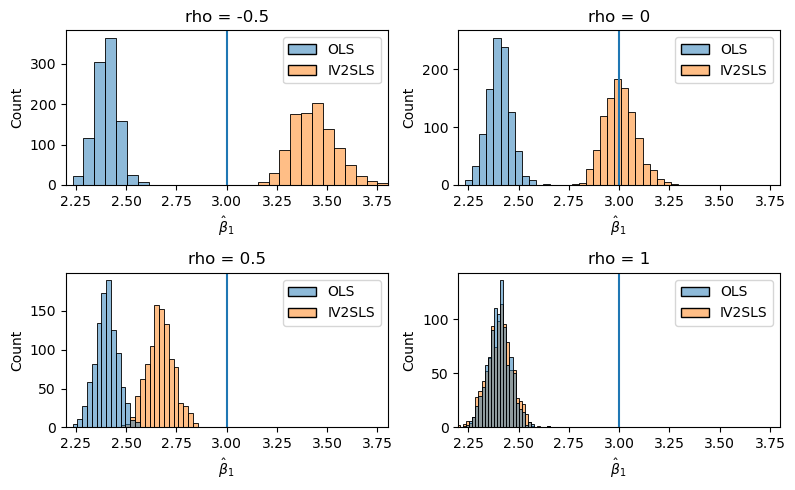

In [23]:
# Create a 4 subplot figure with histograms of the results
plt.figure(figsize=(8, 5))

for i, rho in enumerate(rhos):
    plt.subplot(2, 2, i+1) # Create subplots for each histogram
    sns.histplot(res[i], bins=30) # Plot the histograms
    plt.title(f'rho = {rho}') # Set title

    # Optional pretty stuff:
    plt.axvline(x=3) # Mark the true value of beta1
    plt.xlabel(r'$\hat{\beta}_1$ ') # Fancy LaTeX x-label
    plt.xlim(2.2, 3.8) # Make sure all subplots use the same scale of the x-axis

    # Print means and standard deviations of the estimates
    stats =  res[i].describe().loc[['mean', 'std']].T # Get the mean and std of the estimates
    print()
    print(f'rho = {rho}')
    print(stats)

plt.tight_layout() # Include this line for a pretty layout